In [ ]:
!pip install tensorflow-quantum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.5 MB 6.0 MB/s 
     |████████████████████████████████| 1.8 MB 53.1 MB/s 
     |████████████████████████████████| 541 kB 38.8 MB/s 
     |████████████████████████████████| 90 kB 12.0 MB/s 
     |████████████████████████████████| 90 kB 12.5 MB/s 
     |████████████████████████████████| 100 kB 12.4 MB/s 
     |████████████████████████████████| 6.1 MB 33.6 MB/s 
     |████████████████████████████████| 93 kB 2.0 MB/s 
     |████████████████████████████████| 93 kB 2.2 MB/s 
     |████████████████████████████████| 93 kB 2.3 MB/s 
     |████████████████████████████████| 93 kB 2.1 MB/s 
     |████████████████████████████████| 93 kB 2.1 MB/s 
     |████████████████████████████████| 93 kB 1.8 MB/s 
     |████████████████████████████████| 93 kB 2.0 MB/s 
     |████████████████████████████████| 93 kB 1.7 MB/s 
     |████████████████████████████████| 92 kB 1.6

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq
from tensorflow.keras.layers import LSTM, Dense, Masking, Input, Multiply, Add, Activation, concatenate

import cirq
import sympy
import numpy as np

import pandas as pd
import math

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from cirq.contrib.svg import SVGCircuit

In [ ]:
class QuantumLayer(tf.keras.layers.Layer):

  def __init__(self, enc_symbols, pqc_symbols, ops):
  
    super(QuantumLayer,self).__init__()

    self.enc_symbols = enc_symbols
    self.pqc_symbols = pqc_symbols
    self.all_symbols = enc_symbols + pqc_symbols
    self.ops = ops
    
    init_pqc_values=tf.random.uniform(shape=(1,len(self.pqc_symbols)))
    self.pqc_weights = tf.Variable(initial_value=init_pqc_values,shape=(1,len(self.pqc_symbols)),trainable=True)

  def call(self, inputs):

    # inputs: [tensor circuit, classical output of a previous layer (i.e. classical data to encode)]
    
    upstream_shape = tf.gather(tf.shape(inputs[0]), 0) 
    tiled_up_weights = tf.tile(self.pqc_weights, [upstream_shape, 1])  
    joined_params = tf.concat([inputs[1], tiled_up_weights], 1)    
    
    return tfq.layers.Expectation()(inputs[0],  
                                    operators=self.ops,
                                    symbol_names=self.all_symbols,
                                    symbol_values=joined_params)

class QLSTM(tf.keras.layers.Layer):
    
  def __init__(self, circuit_spec, return_sequence=False, mask_value=None, states_initializer=None, name='QLSTM'):
  
    super(QLSTM, self).__init__(name=name)
    self.return_sequence=return_sequence
    self.mask_value=mask_value
    
    #unpack specifications for each circuit
    spec_f, spec_i, spec_c, spec_o = circuit_spec
    self.n_qubits=spec_f["n_qubits"]

    #forget gate init
    self.wrapper_forget = Dense(self.n_qubits,activation='relu')
    self.quant_forget = QuantumLayer(spec_f["enc_symb"], spec_f["pqc_symb"], spec_f["ops"])
    
    #input gate init
    self.wrapper_input = Dense(self.n_qubits,activation='relu')
    self.quant_input = QuantumLayer(spec_i["enc_symb"], spec_i["pqc_symb"], spec_i["ops"])

    #candidate gate init
    self.wrapper_candidate = Dense(self.n_qubits,activation='relu')
    self.quant_candidate = QuantumLayer(spec_c["enc_symb"], spec_c["pqc_symb"], spec_c["ops"])

    #output gate init
    self.wrapper_output = Dense(self.n_qubits,activation='relu')
    self.quant_output = QuantumLayer(spec_o["enc_symb"], spec_o["pqc_symb"], spec_o["ops"])


    #set the initializer for state h and c

    if states_initializer is None:
        self.states_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
    else:
        self.states_initializer=states_initializer
  
    
  def call(self, inputs): 
    
    #inputs: [circ_f, circ_i, circ_c, circ_o, X]

    circ_f, circ_i, circ_c, circ_o, clas_inp = inputs

    #random initialization of state h and state c 
    batch_size=tf.shape(clas_inp)[0]
    self.state_h = self.states_initializer(shape=(batch_size,self.n_qubits)) 
    self.state_c = self.states_initializer(shape=(batch_size,self.n_qubits))
    
    output_sequence = []
    
    for t in range(clas_inp.shape[1]):
        
      x_t = clas_inp[:,t,:]
      
      if self.mask_value is not None:
        state_h_copy, state_c_copy = tf.identity(self.state_h), tf.identity(self.state_c)
        mask = (x_t != 0.)
        mask = tf.reduce_any(mask, axis=1)
        mask = tf.transpose(tf.stack([mask]*self.n_qubits),perm=[1,0])
      
      concat_inputs = concatenate([self.state_h,x_t],axis=1)
      
      #forwad computations for gates
      forget = self.wrapper_forget(concat_inputs)
      forget = self.quant_forget([circ_f,forget])
      forget = tf.math.sigmoid(forget)
      
      input_ = self.wrapper_input(concat_inputs)
      input_ = self.quant_input([circ_i,input_])
      input_ = tf.math.sigmoid(input_)
      
      candidate = self.wrapper_candidate(concat_inputs)
      candidate = self.quant_candidate([circ_c,candidate])
      candidate = tf.math.tanh(candidate)
      
      output = self.wrapper_output(concat_inputs)
      output = self.quant_output([circ_o,output])
      output = tf.math.sigmoid(output)
      
      #execute pointwise operatios between gates
      self.state_c = Multiply()([forget,self.state_c])
      candidate_accepted = Multiply()([input_,candidate])
      self.state_c = Add()([self.state_c,candidate_accepted])
      state_c_passed_in_tanh = Activation('tanh')(self.state_c)
      self.state_h = Multiply()([state_c_passed_in_tanh,output])
      
      
      if self.mask_value is not None:
        self.state_h = tf.where(mask,self.state_h,state_h_copy)
        self.state_c = tf.where(mask,self.state_c,state_c_copy)

      #append state h to output sequence
      output_sequence.append(self.state_h)
    
    if self.return_sequence:
        output_sequence=tf.stack(output_sequence,axis=1)
        return self.state_h, self.state_c, output_sequence
    else:
        return self.state_h, self.state_c


class QLSTM_Model(tf.keras.Model):

  def __init__(self, circuit_spec, dense_block=[16,8], mask_value=None):
    
    super(QLSTM_Model, self).__init__()
    
    self.qlstm = QLSTM(circuit_spec=circuit_spec, mask_value=mask_value)
    self.dense=[tf.keras.layers.Dense(neurons,activation='relu') for neurons in dense_block]
    self.dense_out = tf.keras.layers.Dense(1)

  def call(self,inp):
    
    #inp: [circ_f,circ_i,circ_c,circ_o,X] where circ_j is a tfq tensor from cirq.Circuit

    out,_ = self.qlstm(inp)
    for layer in self.dense:
      out = layer(out)
    out = self.dense_out(out)

    return out

In [ ]:
def circuit_builder(n_qubits, n_pqc_layers, tag=''):
  
  assert n_qubits>1, "in order to achieve entanglement, please build the circuit with at least 2 qubits"
  qbs=cirq.LineQubit.range(n_qubits)
  ops=[cirq.Z(qbs[qb]) for qb in range(n_qubits)]

  #define the symmbols for the encoding 
  enc_string=''
  for q in range(n_qubits):
    usage='ENC'
    space=' '
    enc_string+=tag+usage+'Qub'+str(q)+space

  enc_symbols = sympy.symbols(enc_string)

  #define the symmbols for the pqc
  layers=[str(i) for i in range(n_pqc_layers)]
  rotations=['Z','Y','X']
  layers_list=[]
  usage='PQC'
  l_symbols=[]
  for layer in layers:
    l_layer=[]
    for q in range(n_qubits):
      l_qub=[]
      for rot in rotations:
        symb = tag+usage+'Layer'+layer+'Qub'+str(q)+'Rot'+rot
        l_qub.append(symb)
      l_layer.append(l_qub)
    l_symbols.append(l_layer)
  pqc_symbols=sympy.symbols(l_symbols)
  
  #create istance of the circuit and append rotations for encoding with enc_symbols as parameters
  circuit = cirq.Circuit()
  circuit.append([cirq.rx(enc_symbols[qb]).on(qbs[qb]) for qb in range(n_qubits)])

  #append pqc layers
  for layer in range(n_pqc_layers):
    for rot in rotations:
      if rot=='Z':
        circuit.append(cirq.Moment([
                        cirq.rz(pqc_symbols[layer][qb][0]).on(qbs[qb]) for qb in range(n_qubits)])
                    )
      elif rot=='Y':
        circuit.append(cirq.Moment([
                        cirq.ry(pqc_symbols[layer][qb][1]).on(qbs[qb]) for qb in range(n_qubits)])
                    )
      elif rot=='X':
        circuit.append(cirq.Moment([
                        cirq.rx(pqc_symbols[layer][qb][2]).on(qbs[qb]) for qb in range(n_qubits)])
                    )


    for qb in range(n_qubits-1):
      circuit.append(cirq.Moment([
                        cirq.CNOT(qbs[qb],qbs[qb+1]) ])
                    )
    if (n_qubits != 2):
      circuit.append( cirq.Moment([
                                   cirq.CNOT(qbs[n_qubits-1],qbs[0]) ])
                      )
  pqc_symbols=[symb for lay_list in pqc_symbols for qub_list in lay_list for symb in qub_list]
  circuit_spec={"enc_symb":list(enc_symbols) ,"pqc_symb":pqc_symbols, "ops": ops, "n_qubits":n_qubits,  "n_pqc_layers":n_pqc_layers}

  return circuit, circuit_spec

In [ ]:
n_qubits=4
n_layers_pqc=2                                         
f_circ, f_spec=circuit_builder(n_qubits, n_layers_pqc, tag='f')
i_circ, i_spec=circuit_builder(n_qubits, n_layers_pqc, tag='i')
c_circ, c_spec=circuit_builder(n_qubits, n_layers_pqc, tag='c')
o_circ, o_spec=circuit_builder(n_qubits, n_layers_pqc, tag='o')

circuit_spec=[f_spec,i_spec,c_spec,o_spec]

#### Test on real data

In [ ]:
def min_max_scaler(df_train,df_test,columns=None,MAX=1,MIN=0):
    
    if columns is None:
        columns = df_train.columns

    for col in columns:
        maximum = df_train.loc[:,col].max()
        minimum = df_train.loc[:,col].min()
        df_train.loc[:,col]=(MAX-MIN)*(df_train.loc[:,col]-maximum)/(maximum-minimum) + MAX
        df_test.loc[:,col]=(MAX-MIN)*(df_test.loc[:,col]-maximum)/(maximum-minimum) + MAX
        
    return df_train, df_test

def make_data(df_input,df_target,n_previous_days):   
    dates=df_input.index.date
    dates=np.unique(dates)
    
    inputs=[]
    outputs=[]
    
    for i in range(dates.shape[0]-n_previous_days):
        
        date0=dates[i].strftime('%Y-%m-%d')
        date1=dates[i+n_previous_days].strftime('%Y-%m-%d')
        
        date1_open_GHR = date1+ ' 11:00:00'
        date1_close_GHR = date1+ ' 14:00:00'
        
        max_ghr = df_target.loc[date1_open_GHR:date1_close_GHR].max()
        
        if math.isnan(max_ghr):
            pass
        
        else:
            
            outputs.append(max_ghr)
            
            date1_till_9 =  date1 +' 09:00:00'
            in_seq = df_input.loc[date0:date1_till_9].to_numpy()

            inputs.append(in_seq)
        
    return np.stack(inputs), np.stack(outputs).reshape(-1,1)

df = pd.read_csv('/content/drive/MyDrive/TESI/3052-Site_Environment-DG_Weather_Station_04-2016_05-2022.csv')
df.Timestamp = df.Timestamp.astype(np.datetime64) #set 'Timestamp' to np.datetime type
df = df.set_index('Timestamp') # set 'Timestamp' column as index
df = df.resample('H').first() #Fill all the missing timesteps with Nan 
df = df.drop(columns=['Hail_Accumulation','Temperature_Probe_1','Temperature_Probe_2','Max_Wind_Speed','Pyranometer_1'])

df=df.loc[(df.index > '2016-05-17 23:00:00')]

unique_dates = np.unique(df.index.date)
split_value=0.8

split_date = unique_dates[int(split_value*unique_dates.shape[0])]
split_date = np.datetime64(split_date)

df_train = df.loc[:(split_date-1).item().strftime('%Y-%m-%d')]
df_test = df.loc[(split_date).item().strftime('%Y-%m-%d'):]

df_train_target=df_train['Global_Horizontal_Radiation'].copy(deep=True)
df_test_target=df_test['Global_Horizontal_Radiation'].copy(deep=True)

df_train_input , df_test_input = min_max_scaler(df_train, df_test)
MASK_VALUE=0.
df_train_input = df_train_input.fillna(MASK_VALUE)
df_test_input = df_test_input.fillna(MASK_VALUE)

inputs_train,outputs_train=make_data(df_train_input,df_train_target,2)
inputs_test,outputs_test=make_data(df_test_input,df_test_target,2)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


In [ ]:
f_circuits=tfq.convert_to_tensor([f_circ for _ in range(inputs_train.shape[0])])
i_circuits=tfq.convert_to_tensor([i_circ for _ in range(inputs_train.shape[0])])
c_circuits=tfq.convert_to_tensor([c_circ for _ in range(inputs_train.shape[0])])
o_circuits=tfq.convert_to_tensor([o_circ for _ in range(inputs_train.shape[0])])

In [ ]:
qmodel = QLSTM_Model(circuit_spec)

In [ ]:
qmodel.compile(loss='mse', optimizer='adam')

In [ ]:
qmodel.fit([f_circuits, i_circuits, c_circuits, o_circuits, inputs_train],outputs_train, epochs=100)

Epoch 1/100
53/53 [==============================] - 283s 4s/step - loss: 809579.3125
Epoch 2/100
53/53 [==============================] - 177s 3s/step - loss: 808479.0625
Epoch 3/100
53/53 [==============================] - 176s 3s/step - loss: 806280.8125
Epoch 4/100
53/53 [==============================] - 176s 3s/step - loss: 802308.7500
Epoch 5/100
53/53 [==============================] - 179s 3s/step - loss: 794949.7500
Epoch 6/100
53/53 [==============================] - 177s 3s/step - loss: 782534.6250
Epoch 7/100
53/53 [==============================] - 176s 3s/step - loss: 765015.3125
Epoch 8/100
53/53 [==============================] - 175s 3s/step - loss: 742424.3125
Epoch 9/100
53/53 [==============================] - 174s 3s/step - loss: 713346.0625
Epoch 10/100
53/53 [==============================] - 174s 3s/step - loss: 676538.5000
Epoch 11/100
53/53 [==============================] - 173s 3s/step - loss: 634354.3125
Epoch 12/100
53/53 [==============================] 

mae: 65.27773
mse: 11270.299
mape: 8.450991


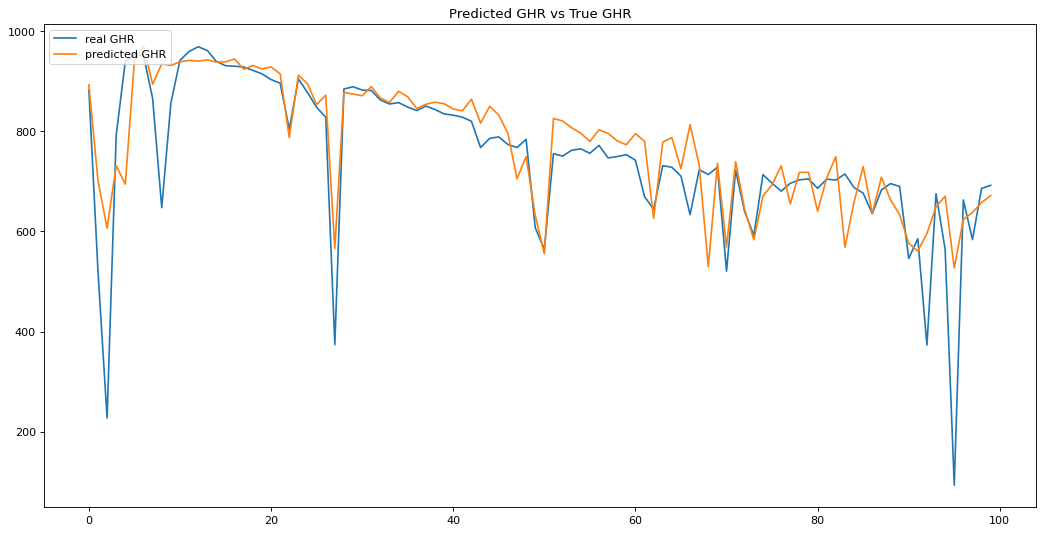

In [ ]:
shp=inputs_test.shape[0]
predictions=qmodel.predict([f_circuits[:shp], i_circuits[:shp], c_circuits[:shp], o_circuits[:shp],inputs_test])

mse=tf.keras.metrics.MeanSquaredError()
mse.update_state(predictions.reshape(-1,), outputs_test.reshape(-1,))

mae= tf.keras.metrics.MeanAbsoluteError()
mae.update_state(predictions.reshape(-1,), outputs_test.reshape(-1,))

mape = tf.keras.metrics.MeanAbsolutePercentageError()
mape.update_state(predictions.reshape(-1,), outputs_test.reshape(-1,))


print('mae: '  +str(mae.result().numpy())) 
print('mse: '  +str(mse.result().numpy()))
print('mape: '  +str(mape.result().numpy())) 


figure(figsize=(16, 8), dpi=80)
plt.title('Predicted GHR vs True GHR')
plt.plot(outputs_test[:100], label='real GHR')
plt.plot(predictions[:100], label='predicted GHR')
plt.legend(loc="upper left")

plt.show()